<a href="https://colab.research.google.com/github/mavalliani/Semantic-Similarity-of-Sentences/blob/master/Smooth_Inverse_Frequency_with_Glove.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import nltk
import spacy
import os
import string
import gensim

In [0]:
train = pd.read_csv("/content/train_2.csv")
train = train.dropna()
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,Q1,Q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"['step', 'step', 'guide', 'invest', 'share', '...","['step', 'step', 'guide', 'invest', 'share', '..."
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"['story', 'kohinoor', 'kohinoor', 'diamond']","['would', 'happen', 'indian', 'government', 's..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"['increase', 'speed', 'internet', 'connection'...","['internet', 'speed', 'increased', 'hacking', ..."
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"['mentally', 'lonely', 'solve']","['find', 'remainder', 'math2324math', 'divided..."
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"['one', 'dissolve', 'water', 'quikly', 'sugar'...","['fish', 'would', 'survive', 'salt', 'water']"


In [0]:
!wget -c http://nlp.stanford.edu/data/glove.840B.300d.zip

In [0]:
import zipfile
with zipfile.ZipFile("/content/glove.840B.300d.zip", "r") as zipread:
  zipread.extractall("/content/")
  zipread.close

In [0]:
import gensim
from gensim.models import Word2Vec
from gensim.scripts.glove2word2vec import glove2word2vec

PATH_TO_GLOVE = "/content/glove.840B.300d.txt"

tmp_file = "/glove.840B.300d.w2v.txt"
glove2word2vec(PATH_TO_GLOVE, tmp_file)
glove = gensim.models.KeyedVectors.load_word2vec_format(tmp_file)


/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
import csv
from ast import literal_eval
PATH_TO_FREQUENCIES_FILE = "/content/frequencies.tsv"

def read_tsv(f):
    frequencies = {}
    with open(f) as tsv:
        tsv_reader = csv.reader(tsv, delimiter="\t")
        for row in tsv_reader: 
            frequencies[row[0]] = int(row[1])
        
    return frequencies
        
frequencies = read_tsv(PATH_TO_FREQUENCIES_FILE)

In [0]:
total_freq = sum(frequencies.values())
total_freq

1082740150

In [0]:
def get_weights(s1, freqs, total_freq, a=0.001):
  weight = [a/(a+freqs.get(word, 0)/total_freq) for word in literal_eval(s1) if word in glove]
  return weight

In [0]:
train["weight1"] = train.Q1.map(lambda x: get_weights(x, frequencies, total_freq, a=0.001))
train["weight2"] = train.Q2.map(lambda x: get_weights(x, frequencies, total_freq, a=0.001))
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,Q1,Q2,weight1,weight2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"['step', 'step', 'guide', 'invest', 'share', '...","['step', 'step', 'guide', 'invest', 'share', '...","[0.9556567694500208, 0.9556567694500208, 0.943...","[0.9556567694500208, 0.9556567694500208, 0.943..."
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"['story', 'kohinoor', 'kohinoor', 'diamond']","['would', 'happen', 'indian', 'government', 's...","[0.839514921500667, 0.9999630580593853, 0.9999...","[0.41668337680663614, 0.9649340962509018, 0.89..."
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"['increase', 'speed', 'internet', 'connection'...","['internet', 'speed', 'increased', 'hacking', ...","[0.9375841663172975, 0.9110805867471258, 0.922...","[0.9227452182038515, 0.9110805867471258, 0.933..."
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"['mentally', 'lonely', 'solve']","['find', 'remainder', 'math2324math', 'divided...","[0.9947201949053784, 0.9939677474154194, 0.985...","[0.7525440337832271, 0.9821554942042321, 0.948..."
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"['one', 'dissolve', 'water', 'quikly', 'sugar'...","['fish', 'would', 'survive', 'salt', 'water']","[0.03339877872379516, 0.9969256384306797, 0.79...","[0.9505073288490751, 0.41668337680663614, 0.98..."


In [0]:
import scipy
from ast import literal_eval
def cosine_distance_wordembedding_method(s1, s2, weight1=None, weight2=None):
    if weight1!=[]:
      vector_1 = np.average([glove[word] for word in literal_eval(s1) if word in glove],axis=0, weights=weight1)
    else:
      return 0
    if weight2!=[]:
      vector_2 = np.average([glove[word] for word in literal_eval(s2) if word in glove],axis=0, weights=weight2)
    else:
      return 0
    cosine = scipy.spatial.distance.cosine(vector_1, vector_2)
    return 1-cosine

In [0]:
train["cos_sim"] = train.apply(lambda x: cosine_distance_wordembedding_method(x.Q1, x.Q2, x.weight1,x.weight2), axis=1)
train.head()

,id,qid1,qid2,question1,question2,is_duplicate,Q1,Q2,weight1,weight2,cos_sim
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,"['step', 'step', 'guide', 'invest', 'share', '...","['step', 'step', 'guide', 'invest', 'share', '...","[0.9556567694500208, 0.9556567694500208, 0.943...","[0.9556567694500208, 0.9556567694500208, 0.943...",0.972475
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,"['story', 'kohinoor', 'kohinoor', 'diamond']","['would', 'happen', 'indian', 'government', 's...","[0.839514921500667, 0.9999630580593853, 0.9999...","[0.41668337680663614, 0.9649340962509018, 0.89...",0.774683
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,"['increase', 'speed', 'internet', 'connection'...","['internet', 'speed', 'increased', 'hacking', ...","[0.9375841663172975, 0.9110805867471258, 0.922...","[0.9227452182038515, 0.9110805867471258, 0.933...",0.877543
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,"['mentally', 'lonely', 'solve']","['find', 'remainder', 'math2324math', 'divided...","[0.9947201949053784, 0.9939677474154194, 0.985...","[0.7525440337832271, 0.9821554942042321, 0.948...",0.384955
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,"['one', 'dissolve', 'water', 'quikly', 'sugar'...","['fish', 'would', 'survive', 'salt', 'water']","[0.03339877872379516, 0.9969256384306797, 0.79...","[0.9505073288490751, 0.41668337680663614, 0.98...",0.719507


In [0]:
train[["is_duplicate", "cos_sim"]].groupby("is_duplicate").mean()

,cos_sim
is_duplicate,
0,0.757515
1,0.897661


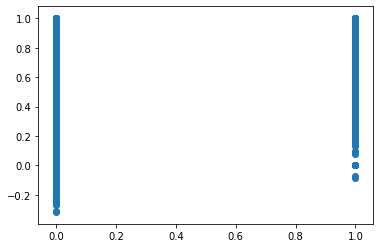

In [0]:
from matplotlib import pyplot as plt

plt.scatter(train["is_duplicate"], train["cos_sim"])

In [0]:
from sklearn.model_selection import train_test_split
train_X, val_X, train_y, val_y = train_test_split(train[["cos_sim"]], train["is_duplicate"], random_state = 0, test_size=0.2)

In [0]:
import xgboost as xgb
options = {"model_param":
         {"eta": 0.15, 
         "max_depth": 4,
         "n_estimators":50,
         "sub_sample":0.5,
         "scale_pos_weight":1.75,
         "random_state":1,
         "eval_metric": "logloss",
         "objective": "binary:logistic"},
         "num_round":50,
         "test_frac":0.2}
#training model
xgbmatrix = xgb.DMatrix(train_X, train_y)
xgb_model = xgb.train(options["model_param"], xgbmatrix, options["num_round"], verbose_eval=10)
xgb_valmatrix = xgb.DMatrix(val_X)
y_val_pred = xgb_model.predict(xgb_valmatrix)
y_val_pred #just checking

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


array([0.45560405, 0.6156892 , 0.28727043, ..., 0.79345644, 0.6826976 ,
       0.33660048], dtype=float32)

In [0]:
y_val_pred_binary = [1 if y>0.5 else 0 for y in y_val_pred]
from sklearn.metrics import confusion_matrix, classification_report

confusion_matrix(val_y, y_val_pred_binary)

array([[29976, 21162],
       [ 6115, 23605]])

In [0]:
from sklearn.metrics import accuracy_score
accuracy_score(val_y, y_val_pred_binary)

0.6626555195527962